In [1]:

from sklearn.model_selection import StratifiedKFold
import bz2
import _pickle as pickle

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import xgboost as xgb
from params import col_nuls,col_less_10, RANDOM_STATE, params_xgb

test = pd.concat([pd.read_pickle('data/aggregation/test.pkl', compression='gzip'),
                pd.read_pickle('data/cross/test.pkl', compression='gzip'),
                pd.read_pickle('data/double_cross/test.pkl', compression='gzip')],axis=1)

target = pd.read_pickle('data/drop_duplicates/target.pkl', compression='gzip')

train = pd.concat([pd.read_pickle('data/aggregation/train.pkl', compression='gzip'),
                pd.read_pickle('data/cross/train.pkl', compression='gzip'),
                pd.read_pickle('data/double_cross/train.pkl', compression='gzip')],axis=1)

scores_train = pd.DataFrame(index = train.index)
scores_test = pd.DataFrame(index = test.index)


In [16]:
SPLITS = 5
scores = {}

kf = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=RANDOM_STATE)
kf.get_n_splits(train)

for fold, (train_index, test_index) in enumerate(kf.split(np.zeros(len(train)), target)):
    test_folds = [fold]

    X_test = train.loc[train.index[test_index]]
    X_train = train.loc[train.index[train_index]]
    
    y_train = target.loc[train.index[train_index]]
    y_test = target.loc[train.index[test_index]]
    
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_test = xgb.DMatrix(X_test, label=y_test)

    watchlist = [(xgb_train, 'train'), (xgb_test, 'eval')]

    eval_result = {}

    model_fit = xgb.train(params_xgb, xgb_train, num_boost_round=1595,
                          evals=watchlist,
                          maximize=False,
                            verbose_eval=False,
                          #early_stopping_rounds = 200,
                            callbacks=[xgb.callback.record_evaluation(eval_result)]
                          )
    
    #model_fit.save_model('models/m'+str(fold)+'.model')
    #model_fit.dump_model('models/m'+str(fold)+'dump.raw.txt', 'models/m'+str(fold)+'featmap.txt')
    with bz2.BZ2File('models/m'+str(fold)+'.pbz2', 'w') as f:
        pickle.dump(model_fit, f)
        
    scores_train.loc[X_test.index, 'xgb_predict'] = model_fit.predict(xgb_test)

    scores[fold] = eval_result['eval']['auc']

scores = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in scores.items()]))

std = scores.std(axis=1)
sco = scores.mean(axis=1)
print(np.argmax(sco), sco.max())

#1595 0.7007046 

1594 0.700691


In [8]:
# train model

train = pd.concat([pd.read_pickle('data/aggregation/train.pkl', compression='gzip'),
                pd.read_pickle('data/cross/train.pkl', compression='gzip'),
                pd.read_pickle('data/double_cross/train.pkl', compression='gzip')],
                axis = 1)

target = pd.read_pickle('data/drop_duplicates/target.pkl', compression='gzip')

#train = train[list(set(train.columns.values) - set(col_nuls) - set(col_less_10))]

xgb_train = xgb.DMatrix(train, label=target)

num_boost_best = 1594
model_fit = xgb.train(params_xgb, xgb_train,
                      num_boost_round=num_boost_best,
                      # evals = watchlist,
                      maximize=True,
                      verbose_eval=False
                      )

with bz2.BZ2File('models/m_main.pbz2', 'w') as f:
    pickle.dump(model_fit, f)

In [17]:
d1 = model_fit.get_score(importance_type='gain')
d2 = model_fit.get_score(importance_type='weight')
features = pd.concat([pd.Series(d1,name='gain').to_frame(),pd.Series(d2,name='weight').to_frame()],axis=1) \
 .sort_values('weight', ascending=False) 
features

,gain,weight
min_lastcredit_time,18.371987,616
mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_5,11.040609,475
sum_CREDIT_TYPE_AMT_CREDIT_SUM_DEBT_4,11.422694,455
mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_DEBT_1_5,11.389756,431
sum_CREDIT_ACTIVE_AMT_CREDIT_SUM_0,12.135388,392
sum_CREDIT_TYPE_AMT_CREDIT_SUM_DEBT_5,10.871191,348
mean_CREDIT_ACTIVE_CREDIT_TYPE_plan_lifetime_1_5,10.455586,345
max_CREDIT_ACTIVE_AMT_CREDIT_MAX_OVERDUE_1,14.794406,345
min_CREDIT_ACTIVE_lastupdate_time_0,10.071232,330
min_CREDIT_ACTIVE_lastcredit_time_1,13.470310,328


In [13]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

In [14]:
SPLITS = 5
scores = []

kf = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=RANDOM_STATE)
kf.get_n_splits(train)

for col in tqdm(train.columns):

    scores_fold = [col]
    for fold, (train_index, test_index) in enumerate(kf.split(np.zeros(len(train)), target)):
        test_folds = [fold]

        X_test = train.loc[train.index[test_index]].copy()
        X_train = train.loc[train.index[train_index]].copy()

        X_test[col] = X_test[col].sample(frac=1, random_state=0).reset_index(drop=True)
        X_train[col] = X_train[col].sample(frac=1, random_state=0).reset_index(drop=True)

        y_train = target.loc[train.index[train_index]].copy()
        y_test = target.loc[train.index[test_index]].copy()

        xgb_train = xgb.DMatrix(X_train, label=y_train)
        xgb_test = xgb.DMatrix(X_test, label=y_test)

        model_fit = xgb.Booster({'nthread': 4})  # init model
        model_fit.load_model('models/m'+str(fold)+'.model')  # load data

        scores_fold.append(roc_auc_score(y_test, model_fit.predict(xgb_test)))
        #train.loc[train.index[test_index], 'xgb_predict'] = model_fit.predict(xgb_test)
    
    scores.append(scores_fold)

100%|██████████| 477/477 [56:10<00:00,  7.07s/it] 


In [18]:
scores = pd.DataFrame(scores,columns = ['col','fold_1','fold_2','fold_3','fold_4','fold_5']).set_index('col')


In [19]:
scores.to_pickle('scores.pkl',compression='gzip')

In [3]:
scores = pd.read_pickle('scores.pkl',compression='gzip')

In [5]:
scores = scores.mean(axis=1).sort_values(ascending=False)

In [11]:
%matplotlib inline

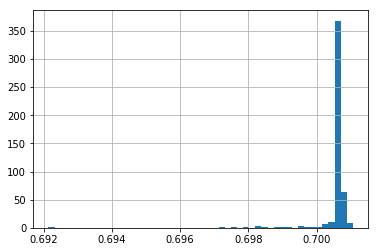

In [13]:
scores.hist(bins=50)

In [9]:
scores.index.values[:100]

array(['min_lastclosed_time', 'mean_CREDIT_TYPE_fact_lifetime_5',
       'mean_CREDIT_ACTIVE_CREDIT_TYPE_plan_lifetime_1_4',
       'mean_CREDIT_TYPE_fact_lifetime_4', 'sum_base', 'sum_CREDIT_DELAY5',
       'min_CREDIT_TYPE_lastcredit_time_5',
       'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_4',
       'max_AMT_CREDIT_MAX_OVERDUE', 'sum_base_0:48', 'sum_zeros_0:36',
       'min_CREDIT_ACTIVE_CREDIT_TYPE_lastcredit_time_0_4',
       'sum_base_0:60', 'mean_CREDIT_TYPE_preschedule_time_5', 'sum_bads',
       'mean_CREDIT_ACTIVE_fact_lifetime_0', 'mean_fact_lifetime',
       'sum_zeros_0:24', 'sum_zeros_0:3',
       'mean_CREDIT_TYPE_preschedule_time_1'], dtype=object)

In [35]:
columns = train.columns.values

In [36]:
columns_test = list(set(columns) - set(['min_lastclosed_time']))

In [37]:
xgb_train = xgb.DMatrix(train, label=target)
cv_res = xgb.cv(params_xgb, xgb_train, num_boost_round=1700, nfold=5, stratified=True, )
score_best = np.max(cv_res['test-auc-mean'])
numboost_best = np.argmax(cv_res['test-auc-mean'])
print (np.argmax(cv_res['test-auc-mean']), np.max(cv_res['test-auc-mean']))

1498 0.6999758


In [38]:

score_best = np.max(cv_res['test-auc-mean'])
numboost_best = np.argmax(cv_res['test-auc-mean'])

In [48]:
columns = scores.index.values

In [51]:
columns = list(columns)

In [55]:
columns = list(set(columns) - set(['min_lastclosed_time']))

In [56]:
def iteration_col():
    global columns, score_best, numboost_best
    for col in columns:
        print(col)
        columns_test = list(set(columns) - set([col]))
        xgb_train = xgb.DMatrix(train[columns_test], label=target)
        
        cv_res = xgb.cv(params_xgb, xgb_train, num_boost_round=1700, nfold=5, stratified=True, )
        score_test_col = np.max(cv_res['test-auc-mean'])
        numboost_test_col = np.argmax(cv_res['test-auc-mean'])
        
        print (score_test_col,numboost_test_col)
        if score_test_col>score_best:
            print('Done')
            score_best = score_test_col
            numboost_best = numboost_test_col
            columns = list(set(columns) - set([col]))
            break

In [57]:
iteration_col()

mean_CREDIT_TYPE_fact_lifetime_1
0.699728 1607
min_CREDIT_CURRENCY_lastupdate_time_eur
0.6998168 1698
mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_8
0.6998168 1698
mean_CREDIT_ACTIVE_CREDIT_TYPE_plan_lifetime_1_0
0.6998168 1698
mean_CREDIT_ACTIVE_CREDIT_TYPE_plan_lifetime_3_19


KeyboardInterrupt: 

In [ ]:
while True:

        